In [1]:
from __future__ import annotations

import gymnasium as gym
from DoubleDQN import DoubleDQNAgent
from DQNAgent import DQNAgent
from DuelingDQNAgent import DuelingDQNAgent
from DuelingDoubleDQN import DuelingDoubleDQNAgent
import matplotlib.pyplot as plt
import wandb

In [2]:
lr = 1e-3
n_episodes = 350
avg_reward_limit = 400
eps_decay = 0.99 #Rate at which to reduce chance of random action being taken
gamma = 0.99 #Discount factor
frame_counter = 0
episode_counter=0
update_target_net = 50
episode_reward_history = 0
plot_reward = []
#Initialize Wandb with the name of the observation.
#wandb.init(name="DQNAgent_SpaceInvaders_Prova",project="deep_rl")

In [3]:
env = gym.make("ALE/SpaceInvaders-v5")
env = gym.wrappers.AtariPreprocessing(env, frame_skip=1) #Frame preprocessing, resize frame to 84x84, following "Play Atari with DeepRL"
env = gym.wrappers.FrameStack(env,4) #Stack frames into groups of 4
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=5) #Returns episode length and reward

In [4]:
agent = DQNAgent(env.action_space.n,lr,gamma, eps_decay)
# agent = DoubleDQNAgent(env.action_space.n,lr,gamma, eps_decay)
# agent = DuelingDQNAgent(env.action_space.n,lr,gamma, eps_decay)
# agent = DuelingDoubleDQNAgent(env.action_space.n,lr,gamma, eps_decay)

In [5]:
for _ in range(n_episodes):
    episode_reward = 0
    done = False
    obs,_ = env.reset()
    
    while not done:
        action = agent.action_selection(obs,frame_counter)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        #next_obs = np.array(next_obs)
        done = terminated or truncated
        agent.remember(obs,action, reward,next_obs, done)
        
        frame_counter+=1
        episode_reward += reward
        obs = next_obs

        #If the buffer reaches the batch limit and the last frame of the stack is processed
        #Train the network
        if len(agent.buffer)>agent.batch_size and frame_counter%4==0:
            agent.replay()
        
        #Only for DoubleDQN family
        if frame_counter % update_target_net == 0:
            agent.update_target_net()
    
    #Counter the total reward overtime and the number of episodes
    episode_counter += 1
    episode_reward_history += episode_reward
    #Average of the rewards over episodes
    avg_reward = episode_reward_history // episode_counter
    plot_reward.append(avg_reward)

    #Save the model every 100 episodes
    # if episode_counter % 100 == 0:
    #     agent.net.save_model("./saved_models/DuelingDoubleDQN_spaceinvaders.h5")

    # if len(env.return_queue) != 0 and len(env.length_queue) != 0:
    #     wandb.log({'Episode Rewards:':np.array(env.return_queue).flatten()[-1],'Episode Lengths':np.array(env.length_queue).flatten()[-1],'Episode Running Rewards:':avg_reward})
    # else:
    #     wandb.log({'Episode Running Rewards:':avg_reward})

    if avg_reward > avg_reward_limit:
        print('Achieved target avg reward on episode {}'.format(episode_counter))
        break
print('Reached Limit of episodes')

1/1 [==============================] - 0s 13ms/step


KeyboardInterrupt: 

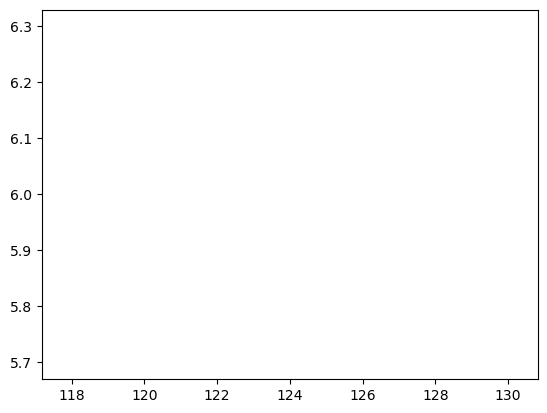

In [6]:
plt.plot(plot_reward,episode_counter)